In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import scipy
import os

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

## Model structure

In [5]:
base_model = keras.applications.ResNet50(weights="imagenet", include_top=False)

# base_model = keras.applications.Xception(weights="imagenet", include_top=False)
# base_model = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_shape=(224,224,3))
# base_model = keras.applications.EfficientNetB7(weights="imagenet", include_top=False,input_shape=(224,224,3))


base_model.trainable = False


inputs = keras.Input(shape=(224,224,3))
# inputs = keras.Input(shape=(299,299,3))


x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
# # x = keras.layers.Flatten()(x)
# x = keras.layers.Dropout(0.2)(x)
# x = keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.L1(0.01))(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.L1(0.01))(x)

# x = keras.layers.Dense(8, activation='relu')(x)
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer='adam',
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                65568     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 23,653,313
Trainable params: 65,601
Non-trainable params: 23,587,712
____________________________________________

## Read Data

In [7]:
os.getcwd()

'/Users/joonghochoi/Desktop/Transfer_learning_zillow'

In [8]:
df_data=pd.read_csv('df_selected_final.csv',sep=',',header=0)
df_data.head()

,Unnamed: 0,zpid,time,price,week,dow,month,year,latitude,longitude,...,unitCount,stories,lastRemodelYear,solarPotential,zestimate,zestimateHighPercent,zestimateLowPercent,rentZestimate,taxEstimate,n_round
0,15,11252639,2020-07-30,329600,31,Thursday,7,20,40.390975,-80.067424,...,0,1,1959,86.82,388800,8,7,2504,561800,69
1,18,11252786,2020-11-16,787000,47,Monday,11,20,40.387805,-80.072098,...,0,2,1958,90.02,884800,6,6,3830,722659,69
2,19,11252802,2020-06-24,504715,26,Wednesday,6,20,40.388525,-80.068769,...,0,1,1948,92.42,600200,8,7,3894,626265,69
3,20,11253008,2020-06-22,755000,26,Monday,6,20,40.386178,-80.070577,...,0,2,1977,87.62,901300,8,7,5751,1102648,69
4,21,11253033,2020-10-01,800000,40,Thursday,10,20,40.385030,-80.068198,...,0,2,1953,88.42,918100,7,6,3160,629218,69


In [9]:
df_data.shape

(853, 35)

In [15]:
import glob

list_all_pic=glob.glob('1_images/*/0*.jp*')+glob.glob('1_images/*/*/0*.jp*')+ glob.glob('1_images/*/*/*/0*.jp*')
list_all_pic_filtered=[i for i in list_all_pic if ('_' not in i.split('/')[-2]) and ('nan' not in i.split('/')[-2])]
dict_zpid_pic_path={int(i.split('/')[-2]):i for i in list_all_pic_filtered}
len(list_all_pic),len(list_all_pic_filtered)


(789, 674)

In [16]:
df_data['pic_path']=df_data['zpid'].apply(lambda x: dict_zpid_pic_path[x] if x in dict_zpid_pic_path else "NA")
df_data_filtered=df_data[df_data['pic_path']!='NA']
df_data_filtered.shape

(667, 36)

In [17]:
df_data_filtered['price_log'] = df_data_filtered['price'].apply(np.log)

<ipython-input-17-8441e1a4237f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_filtered['price_log'] = df_data_filtered['price'].apply(np.log)


## Pre-process

In [18]:
images=[keras.preprocessing.image.load_img(i, target_size=(224, 224)) for i in df_data_filtered['pic_path']]
# images=[keras.preprocessing.image.load_img(i, target_size=(299, 299)) for i in df_data_filtered['pic_path']]
images=[keras.preprocessing.image.img_to_array(i) for i in images]
images=np.array(images)
# image = np.expand_dims(image, axis=0)
images = keras.applications.resnet50.preprocess_input(images)
# images = keras.applications.xception.preprocess_input(images)
# images = keras.applications.mobilenet_v2.preprocess_input(images)
# images = keras.applications.efficientnet.preprocess_input(images)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# train_imgs=images[:-50]
# val_imgs=images[-50:]
# # train_price=np.array(df_data_filtered['price'].tolist()[:-50])/1e5
# # val_price=np.array(df_data_filtered['price'].tolist()[-50:])/1e5
# train_price=np.array(df_data_filtered['price'].tolist()[:-50])/1e6
# val_price=np.array(df_data_filtered['price'].tolist()[-50:])/1e6

train_imgs, val_imgs, train_price, val_price = train_test_split(images, 
                                                                np.array(df_data_filtered['price_log'].tolist())/1e6,
                                                                test_size=0.3, random_state=66)
standard_scaler = preprocessing.StandardScaler()
train_price = standard_scaler.fit_transform(train_price.reshape(-1, 1))
val_price = standard_scaler.transform(val_price.reshape(-1, 1))

# min_max_scaler = preprocessing.MinMaxScaler()
# train_price = min_max_scaler.fit_transform(train_price.reshape(-1, 1))
# val_price = min_max_scaler.transform(val_price.reshape(-1, 1))

In [20]:
max(train_price)

array([2.76680365])

## Model Training

In [21]:
history = model.fit(x=train_imgs, y=train_price,
                    validation_data=(val_imgs, val_price),
                    batch_size=30,
                    epochs=50,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error', patience=5)],
                    verbose=1)

Epoch 1/50
16/16 [==============================] - 46s 3s/step - loss: 17.9496 - root_mean_squared_error: 1.2856 - val_loss: 15.8270 - val_root_mean_squared_error: 1.0467
Epoch 2/50
16/16 [==============================] - 43s 3s/step - loss: 14.1920 - root_mean_squared_error: 0.9371 - val_loss: 12.6111 - val_root_mean_squared_error: 0.9870
Epoch 3/50
16/16 [==============================] - 42s 3s/step - loss: 11.1368 - root_mean_squared_error: 0.8817 - val_loss: 9.8119 - val_root_mean_squared_error: 0.9333
Epoch 4/50
16/16 [==============================] - 41s 3s/step - loss: 8.6662 - root_mean_squared_error: 0.8295 - val_loss: 7.7803 - val_root_mean_squared_error: 0.9177
Epoch 5/50
16/16 [==============================] - 41s 3s/step - loss: 6.8897 - root_mean_squared_error: 0.8090 - val_loss: 6.3245 - val_root_mean_squared_error: 0.9182
Epoch 6/50
16/16 [==============================] - 41s 3s/step - loss: 5.6662 - root_mean_squared_error: 0.8323 - val_loss: 5.2000 - val_root_me

In [22]:
# for ind,i in enumerate(predict_prices):
#     print("%.3f" % i[0],val_price[ind])

## Results explore

<AxesSubplot:>

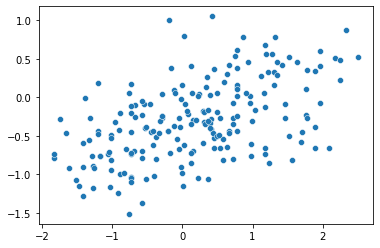

In [23]:
import seaborn as sns

predict_prices=model.predict(val_imgs)
sns.scatterplot(y=predict_prices.flatten(),x=val_price.flatten())

In [24]:
#sns.scatterplot(y=np.exp(predict_prices.flatten()),x=np.exp(val_price.flatten()))

In [25]:
np.mean(abs(predict_prices.flatten() - val_price.flatten())/abs(val_price.flatten()))

5.272223402187642

In [26]:
np.mean(abs(np.exp(predict_prices.flatten()) - np.exp(val_price.flatten()))/abs(np.exp(val_price.flatten())))

0.5967008096365621

In [27]:
scipy.stats.pearsonr(predict_prices.flatten(),val_price.flatten())

(0.517810061167655, 3.494822349285665e-15)

<AxesSubplot:>

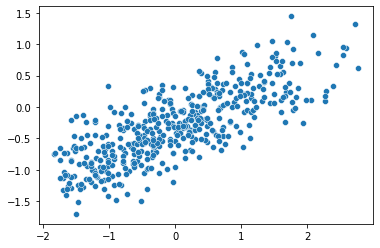

In [28]:
predict_prices=model.predict(train_imgs)

sns.scatterplot(y=predict_prices.flatten(),x=train_price.flatten())

In [29]:
np.mean(abs(predict_prices.flatten() - train_price.flatten())/abs(train_price.flatten()))

2.502612615312185

In [30]:
np.mean(abs(np.exp(predict_prices.flatten()) - np.exp(train_price.flatten()))/abs(np.exp(train_price.flatten())))

0.4864692476655385

In [31]:
scipy.stats.pearsonr(predict_prices.flatten(),train_price.flatten())

(0.7732388870644897, 7.681050692208392e-94)

## Output layer information

In [32]:
layer_name = 'dense'
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.get_layer(layer_name).output)



In [33]:
intermediate_output = intermediate_layer_model(images)


In [34]:
intermediate_output.shape

TensorShape([667, 32])

In [35]:
df_out_feature=pd.DataFrame(np.array(intermediate_output),index=df_data_filtered['zpid'].to_list(),columns=['feature_%d' % i for i in range(1,33)])

In [36]:
df_out_feature.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32
11252639,1.847447,0.163348,0.0,0.0,0.0,1.170019,0.0,1.686276,0.0,0.0,...,0.0,0.0,0.0,0.941279,0.0,0.0,0.0,0.0,0.224420,0.0
11252786,1.921577,0.000000,0.0,0.0,0.0,1.689191,0.0,1.125005,0.0,0.0,...,0.0,0.0,0.0,0.782110,0.0,0.0,0.0,0.0,0.068054,0.0
11252802,2.158650,0.297144,0.0,0.0,0.0,1.518946,0.0,1.258660,0.0,0.0,...,0.0,0.0,0.0,1.385096,0.0,0.0,0.0,0.0,1.090448,0.0
11253008,2.820886,0.000000,0.0,0.0,0.0,0.513527,0.0,0.858836,0.0,0.0,...,0.0,0.0,0.0,1.344304,0.0,0.0,0.0,0.0,0.000000,0.0
11253033,2.424710,0.245461,0.0,0.0,0.0,1.455600,0.0,1.506473,0.0,0.0,...,0.0,0.0,0.0,0.723790,0.0,0.0,0.0,0.0,0.000000,0.0


In [37]:
df_out_feature['feature_2'].unique()

array([1.63347811e-01, 0.00000000e+00, 2.97143757e-01, 2.45460749e-01,
       2.71558791e-01, 2.26891071e-01, 7.47943819e-02, 2.82870382e-01,
       2.76801676e-01, 1.67133301e-01, 3.79782051e-01, 4.41912085e-01,
       1.05700350e+00, 5.30116379e-01, 8.78100395e-01, 4.83280182e-01,
       6.03627115e-02, 2.56237119e-01, 4.00435537e-01, 3.24753433e-01,
       3.44248921e-01, 7.99508989e-01, 9.21443999e-02, 5.96135736e-01,
       2.95083374e-01, 9.94700491e-02, 3.82553115e-02, 4.28867251e-01,
       1.94032565e-01, 9.93376672e-02, 2.67771572e-01, 6.55504346e-01,
       7.37260342e-01, 8.22127879e-01, 3.88536155e-01, 1.10890426e-01,
       1.15595043e-01, 3.42371225e-01, 5.22926807e-01, 5.20845294e-01,
       4.05840069e-01, 2.24030927e-01, 3.77149016e-01, 2.93812901e-01,
       5.71548864e-02, 7.38355696e-01, 7.81388581e-02, 2.81840712e-01,
       4.80237836e-03, 4.21137899e-01, 1.70267090e-01, 5.00180900e-01,
       1.28575182e+00, 2.94209868e-01, 5.96919060e-01, 5.11141777e-01,
      

In [38]:
df_out_feature['zpid']=df_out_feature.index

In [39]:
df_out_feature.to_csv('TL_features.csv',sep=',',header=True,index=False)

In [40]:
df_temp=df_out_feature.describe()

In [41]:
df_temp.loc['std']

feature_1     7.380129e-01
feature_2     3.677261e-01
feature_3     0.000000e+00
feature_4     1.954720e-02
feature_5     0.000000e+00
feature_6     6.010909e-01
feature_7     0.000000e+00
feature_8     6.174949e-01
feature_9     0.000000e+00
feature_10    5.160612e-02
feature_11    3.312533e-01
feature_12    3.825422e-02
feature_13    1.135818e-02
feature_14    1.687812e-02
feature_15    8.822115e-04
feature_16    1.872142e-02
feature_17    3.138171e-01
feature_18    3.631982e-02
feature_19    9.587368e-02
feature_20    4.037602e-01
feature_21    0.000000e+00
feature_22    0.000000e+00
feature_23    3.138857e-02
feature_24    3.340733e-02
feature_25    0.000000e+00
feature_26    3.498513e-01
feature_27    1.665126e-02
feature_28    0.000000e+00
feature_29    4.184730e-02
feature_30    0.000000e+00
feature_31    1.655262e-01
feature_32    0.000000e+00
zpid          1.368045e+07
Name: std, dtype: float64

## Test

In [44]:
os.getcwd()

'/Users/joonghochoi/Desktop/Transfer_learning_zillow'

In [45]:
ls

1_images/                               df_selected_final.csv
1_images.zip                            image_downloader.txt
TL_features.csv                         post_transfer_pred_salesprice copy.Rmd
Transfer-Learning_v2.ipynb


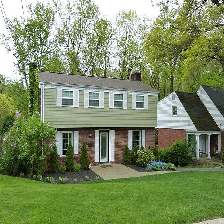

In [48]:
imagePath='1_images/1_image_zoey_1_50/11311273/0.jpeg'

image = keras.preprocessing.image.load_img(imagePath, target_size=(224, 224))
image

In [49]:
image = keras.preprocessing.image.img_to_array(image)
image = np.expand_dims(image, axis=0)
image = keras.applications.resnet50.preprocess_input(image)


In [50]:
image.shape

(1, 224, 224, 3)

In [51]:
features = base_model.predict(image)
# features = features.reshape((features.shape[0], 7 * 7 * 2048))
features = features.reshape((features.shape[0], -1))

In [52]:
features.shape

(1, 100352)

In [53]:
pd.Series(features[0,:]).value_counts()

0.000000    85480
0.930822        2
4.894685        2
0.670810        2
1.401433        2
            ...  
7.652251        1
0.625693        1
0.329053        1
1.165685        1
3.080730        1
Length: 14868, dtype: int64

In [ ]:
s